# Importing

In [230]:
import numpy as np
import astropy
from scipy.optimize import curve_fit
from scipy import interpolate
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from astropy.io import fits
import os
from scipy.stats import linregress

from astroquery.astrometry_net import AstrometryNet
ast=AstrometryNet()
import glob

from astropy.coordinates import SkyCoord  # High-level coordinates
from astropy.coordinates import ICRS, Galactic, FK4, FK5  # Low-level frames
from astropy.coordinates import Angle, Latitude, Longitude  # Angles
import astropy.units as u

import photutils
from photutils.aperture import SkyCircularAperture
from photutils.datasets import make_4gaussians_image
from astropy.stats import sigma_clipped_stats
from photutils.aperture import CircularAperture, ApertureStats

from astropy.wcs import WCS

# API Key

In [9]:
#Changing working directory to folder with images
os.chdir('C:/Users/Ethan/Desktop/Fall 2022/4410 Astro/Lab 2/Lab2Data')

#Setting and retrieving api_key
import keyring
keyring.set_password('astroquery:astrometry_net', 'Ethan', 'kgqbaieixpgbzpkm')
api_key = keyring.get_password('astroquery:astrometry_net', 'Ethan')
ast.api_key = api_key

# Obtaining WCS Headers

In [11]:
#Testing obtaining headers without force_image_upload
wcs_header=ast.solve_from_image('CCD Image 236.fit')
print(wcs_header)

Determining background stats
Finding sources
Found 10 sources


 id     xcentroid      ...        flux                 mag         
--- ------------------ ... ------------------ ---------------------
  4  1630.904445490279 ... 56.601290216626445    -4.382065827421868
  3 467.87030375241096 ...  32.04194276274032   -3.7642971007370196
  5  345.4433555301173 ...  9.712686653177434     -2.46834844481614
  7 1715.2622482421164 ... 3.8734204442071776   -1.4702366011591803
 10  971.8265713156642 ... 1.4856345696825335  -0.42977999144914064
  8 1685.7435993129363 ... 1.3970349923692718   -0.3630182107087865
  9  971.9999595879364 ... 1.1771046292592011   -0.1770376691951393
  2  450.8819095477387 ...  1.055240412056142 -0.058378537081448856
  6 1383.8672523688301 ... 1.0256835629941439 -0.027533489555630633
  1  452.3865777261016 ... 1.0163001183348168  -0.01755494036644725
Solving....................{}


##### Without using force_image_upload = True the header is empty, but we get a selection of notable points in the image (including the 2 Tycho stars)

In [57]:
#Testing obtaining headers using force_image_upload
#wcs_header = ast.solve_from_image('CCD Image 236.fit', force_image_upload=True)

##### Using force_image_upload actually generates a new WCS header including the RA and Dec we are looking for. It also uploads the data to astrometry.net and does not list the notable points in the image here.

##### We can write a script to generate these headers for each image, and subsequently write these headers + the original exposure time, observation date and julian date to a new file (located in a single folder together). It will probably take a long time to run (upwards of a couple of hours?)

##### For each image 236-450, 
##### - generate a new header using ast.solve_from_image with force_image_upload = true. 
##### - write this header to a new file (separate file for each image) and also include the original EXP_TIME, DATE-OBS, and JD (if not already included, check using code and DS9?)

#Index for looping through each image
imageNo = 341

while imageNo <= 450:
    #Obtaining WCS header
    print(f'We are on image {imageNo}')
    wcs_header = ast.solve_from_image(f'CCD Image {imageNo}.fit', force_image_upload = True, solve_timeout=300)

    #Opening FITS file
    fitsPath = f'CCD Image {imageNo}.fit'
    openedFile = fits.open(fitsPath)

    #Obtaining the header and original exptime, date observed and JD info
    header = openedFile[0].header
    exptime = header['EXPTIME']
    date_obs = header['DATE-OBS']
    jd = header['JD']

    #Making a copy of the original FITS file in the new folder
    openedFile.writeto(f'C:/Users/Ethan/Desktop/Fall 2022/4410 Astro/Lab 2/New FITS Headers/WCS CCD Image {imageNo}.fits', overwrite = True)

    #Updating the copy FITS file header with the WCS header
    copyFitsPath = f'C:/Users/Ethan/Desktop/Fall 2022/4410 Astro/Lab 2/New FITS Headers/WCS CCD Image {imageNo}.fits'
    with fits.open(copyFitsPath, 'update') as f:
        f[0].header.update(wcs_header.cards)
        f[0].header['EXPTIME'] = exptime
        f[0].header['DATE-OBS'] = date_obs
        f[0].header['JD'] = jd

    #Closing copy FITS file
    openedCopyFile.close()
                                      
    #Move on to next image
    imageNo = imageNo + 1

##### Now the FITS files open in DS9 with FK5 coordinates for RA and Dec (which are sufficiently close to the ICRS RA and Dec that any difference is negligible. The next step is obtaining the Julian dates for each image, and using the Horizons database to obtain the Ra and Dec of the asteroid at all of these times (i.e. for every image). After this, these asteroid coordinates can be used for the aperture photometry.

# Finding the asteroid

In [274]:
from astroquery.jplhorizons import Horizons
os.chdir('C:/Users/Ethan/Desktop/Fall 2022/4410 Astro/Lab 2/New Fits Headers')

#Obtaining the Julian dates for each image and throwing the data from each opened image into a new file
jdList = []
imageData= []
imageNo = 236
while imageNo <= 450:
    fitsPath = f'WCS CCD Image {imageNo}.fits'
    openedFile = fits.open(fitsPath)
    imageDataArray = fits.getdata(fitsPath)
    imageData.append(imageDataArray)
    jdList.append(openedFile[0].header['JD'])
    openedFile.close()
    imageNo = imageNo + 1

In [262]:
#Obtaining the RA and DEC of bourgeois in each image and putting them in a list
imageNo = 236
listCounter = 0
raDecList = []
while imageNo <= 450:
    bourgeois = Horizons(id='1543', location='H81', epochs=jdList[listCounter])
    eph = bourgeois.ephemerides()
    raDec = SkyCoord(ra = eph['RA'], dec = eph['DEC'])
    raDecCoord = raDec.to_string('hmsdms')
    raDecList.append(raDecCoord)
    imageNo = imageNo + 1
    listCounter = listCounter + 1

##### raDecList now contains all the right ascension and declination coordinates for the asteroid for each image based on its Julian date. Creating an aperture around the asteroid for all images now can allow us to track its brightness over time. This requires finding a way to properly translate the RA and Dec coords into locations in the image.

##### raDecList is also a 2D list (by accident, but I am lazy to fix it) of dimensions 214 x 1, so using raDecList[imageNo][0] is enough to extract the coordinate as a string, which we can split after the space into ra and dec.

# Bias and flats

In [307]:
#Finding bias
os.chdir('C:/Users/Ethan/Desktop/Fall 2022/4410 Astro/Lab 2/Bias')
imageAvgArray = []
v=51
while v<=60:
    path=f'Flat_V-0{v}bias.fit'
    openedImage = fits.open(path)
    imageDataBias = fits.getdata(path)
    imageAvg = np.mean(imageDataBias)
    imageAvgArray.append(imageAvg)
    openedImage.close()
    v=v+1
bias = np.mean(imageAvgArray)
print(bias)

#Averaging flats
os.chdir('C:/Users/Ethan/Desktop/Fall 2022/4410 Astro/Lab 2/Flat')
flatsAvgArray = []
v=51
while v<=70:
    path=f'Flat_V-0{v}flat.fit'
    openedImage = fits.open(path)
    imageDataFlat = fits.getdata(path)
    imageAvg = np.mean(imageDataFlat)-bias
    flatsAvgArray.append(imageAvg)
    openedImage.close()
    v=v+1
avgFlat = np.mean(flatsAvgArray)

normalizedFlatField = (avgFlat-bias)/avgFlat #now for each image, sub bias and divide by this value.
print(normalizedFlatField)

157.1210012435913
0.8316179251959824


##### We will NOT have to re-obtain the WCS headers for each image so we can use ApertureStats. This code was a mistake. I hate it here

os.chdir('C:/Users/Ethan/Desktop/Fall 2022/4410 Astro/Lab 2/Lab2Data')
wcs_headerList = []
imageNo = 298
while imageNo <= 450:
    #Obtaining WCS header
    print(f'We are on image {imageNo}')
    wcs_header = ast.solve_from_image(f'CCD Image {imageNo}.fit', force_image_upload = True, solve_timeout=300)
    wcs_headerList.append(wcs_header)
    imageNo = imageNo + 1

imageNo = 236
index = 0
while imageNo <= 297:
    print(f'We are on image {imageNo}')
    wcs_header = ast.solve_from_image(f'CCD Image {imageNo}.fit', force_image_upload = True, solve_timeout = 300)
    wcs_headerList[index]=wcs_header
    imageNo = imageNo + 1
    index = index + 1

In [146]:
#input wcs headers into list, which stopped right before image 300, but instead of continuing to append to array
#accidentially reset array and went on from that image
#then, attempted to stick the first 60 or so image wcs headers in the front of the list but input the wrong item
#now, simply replacing the first 60 or so elements with the right headers
#i guess it's not headers it wants? but a wcs object alone?

##### Yes, it is a WCS object it wants. We can cycle through each image in the New FITS headers files and get wcs objects for each.

In [269]:
os.chdir('C:/Users/Ethan/Desktop/Fall 2022/4410 Astro/Lab 2/New FITS Headers')
wcsObjs = []
imageNo = 236
while imageNo <= 450:
    fitsPath = f'WCS CCD Image {imageNo}.fits'
    openedFile = fits.open(fitsPath)
    wcs = WCS(openedFile[0].header)
    wcsObjs.append(wcs)
    imageNo = imageNo + 1

# Asteroid aperture

In [308]:
#Creating apertures around the asteroid for each image and putting the means of the aperture in an array
imageNo = 0
bourgeoisMeanArray = []
for image in imageData:
    currentCoords = raDecList[imageNo][0] #the 0 is because the ra and dec are originally a string in a 0D list
    seperatedCoords = currentCoords.split(' ')
    positions = SkyCoord(ra=seperatedCoords[0], dec=seperatedCoords[1])
    aperture = SkyCircularAperture(positions, r=4.8*u.arcsec)
    phot_table = photutils.aperture.aperture_photometry(apertures=aperture, data=imageData[imageNo]/normalizedFlatField, wcs=wcsObjsList[imageNo])
    print(aperture)
    bourgeoisMeanArray.append(phot_table['aperture_sum'].value)
    #aperstats = ApertureStats(aperture=aperture, data=imageData[imageNo], wcs=wcsObjsList[imageNo])
    #bourgeoisMeanArray.append(aperstats.mean)
    imageNo = imageNo + 1

Aperture: SkyCircularAperture
positions: <SkyCoord (ICRS): (ra, dec) in deg
    (314.39829, -0.6908)>
r: 4.8 arcsec
Aperture: SkyCircularAperture
positions: <SkyCoord (ICRS): (ra, dec) in deg
    (314.39823, -0.69078)>
r: 4.8 arcsec
Aperture: SkyCircularAperture
positions: <SkyCoord (ICRS): (ra, dec) in deg
    (314.39817, -0.69076)>
r: 4.8 arcsec
Aperture: SkyCircularAperture
positions: <SkyCoord (ICRS): (ra, dec) in deg
    (314.39812, -0.69074)>
r: 4.8 arcsec
Aperture: SkyCircularAperture
positions: <SkyCoord (ICRS): (ra, dec) in deg
    (314.39806, -0.69072)>
r: 4.8 arcsec
Aperture: SkyCircularAperture
positions: <SkyCoord (ICRS): (ra, dec) in deg
    (314.39801, -0.69071)>
r: 4.8 arcsec
Aperture: SkyCircularAperture
positions: <SkyCoord (ICRS): (ra, dec) in deg
    (314.39795, -0.69069)>
r: 4.8 arcsec
Aperture: SkyCircularAperture
positions: <SkyCoord (ICRS): (ra, dec) in deg
    (314.39789, -0.69067)>
r: 4.8 arcsec
Aperture: SkyCircularAperture
positions: <SkyCoord (ICRS): (ra, d

##### These apertures match Thomas' exactly in the github code. 

# Star 1 aperture

In [309]:
#Creating apertures around the check stars for each image (same coordinates each time) and putting their means in an array
imageNumber=0
star1MeanArray = []
for image in imageData:
    star1Pos = SkyCoord(ra='20h57m39.4086s', dec='-00d41m54.929s')
    apertureStar1 = SkyCircularAperture(star1Pos, r=4.8*u.arcsec)
    phot_tableStar1 = photutils.aperture.aperture_photometry(apertures=apertureStar1, data=imageData[imageNumber]/normalizedFlatField, wcs=wcsObjsList[imageNumber])
    star1MeanArray.append(phot_tableStar1['aperture_sum'].value)
    imageNumber=imageNumber+1

In [310]:
#Taking the ratio of the asteroid with the reference star
bourgeoisStar1Ratio = []
a=0
for element in bourgeoisMeanArray:
    bourgeoisStar1Ratio.append(bourgeoisMeanArray[a][0]/star1MeanArray[a][0])
    a=a+1

# Plots

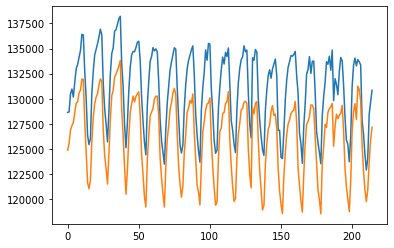

In [311]:
plt.plot(bourgeoisMeanArray)
plt.plot(star1MeanArray)

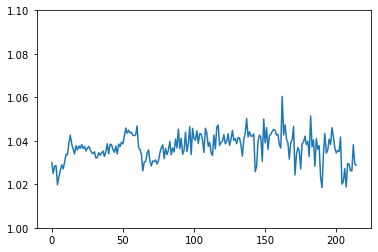

In [312]:
plt.ylim([1,1.1])
plt.plot(bourgeoisStar1Ratio)